In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import math
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [2]:
def load_target(frame):

    # target_file="/content/13.png"   
    target_file='/content/golem.0'+str(frame)+'.png'
    G_T = img.imread(target_file)[:,:,: 3]
    A_T = img.imread(target_file)[:,:,3]
    plt.imshow(G_T)
    plt.show()

    plt.imshow(A_T)

    print(A_T.shape)
    return G_T,A_T

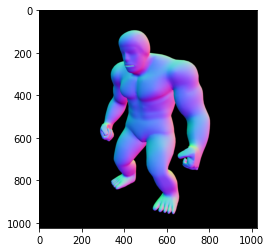

(1024, 1024)


(1024, 1024, 3)

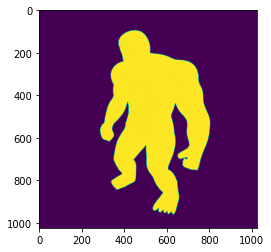

In [3]:
g_t,a_t= load_target('01')
g_t.shape

In [ ]:
# load_target('01')

In [ ]:
def position_features(h,w):
  print("h:",h)
  print("w:",w)

  x = np.arange(1,w+1) 
  print("x: ",x)
  y = np.arange(1,h+1) 
  print("y: ",y)

  X,Y = np.meshgrid(x,y)
  

  print("X: ",X)
  print("Y: ",Y)
  
  P=np.dstack((Y, np.atleast_3d(X)))
  # P=np.concatenate((Y, X), axis = 0).reshape((len(Y),len(Y[0]),-1))
  print("P: ",P)

  scaler = math.sqrt(w*h);
  P = P / scaler;


  return P, scaler

In [ ]:
h,w = g_t.shape[:2]
P, scaler = position_features(h,w)
print(P.shape)

h: 1024
w: 1024
x:  [   1    2    3 ... 1022 1023 1024]
y:  [   1    2    3 ... 1022 1023 1024]
X:  [[   1    2    3 ... 1022 1023 1024]
 [   1    2    3 ... 1022 1023 1024]
 [   1    2    3 ... 1022 1023 1024]
 ...
 [   1    2    3 ... 1022 1023 1024]
 [   1    2    3 ... 1022 1023 1024]
 [   1    2    3 ... 1022 1023 1024]]
Y:  [[   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 [   3    3    3 ...    3    3    3]
 ...
 [1022 1022 1022 ... 1022 1022 1022]
 [1023 1023 1023 ... 1023 1023 1023]
 [1024 1024 1024 ... 1024 1024 1024]]
P:  [[[   1    1]
  [   1    2]
  [   1    3]
  ...
  [   1 1022]
  [   1 1023]
  [   1 1024]]

 [[   2    1]
  [   2    2]
  [   2    3]
  ...
  [   2 1022]
  [   2 1023]
  [   2 1024]]

 [[   3    1]
  [   3    2]
  [   3    3]
  ...
  [   3 1022]
  [   3 1023]
  [   3 1024]]

 ...

 [[1022    1]
  [1022    2]
  [1022    3]
  ...
  [1022 1022]
  [1022 1023]
  [1022 1024]]

 [[1023    1]
  [1023    2]
  [1023    3]
  ...
  [1023 1022]


In [ ]:
# P[0:11,0:11,0]

In [ ]:
def region_of_interest(A_X,X):
  roi = []
  idx=[]
  for i in range(len(A_X)):
    if(A_X[i]>0.0):
      roi.append(X[i,:])
      idx.append(i)
  # print("roi:",roi)
  return np.array(roi),np.array(idx)
  

In [ ]:
def x_region_of_interest(x_roi,sample_ids):
  roi1 = []
  for i in sample_ids:
    roi1.append(x_roi[i])
  return roi1

In [ ]:
import random
def randint(num_roi, num_samples):
  beg=1
  end=num_roi
  arr=[]
  for i in range(num_samples+1):
    arr.append(random.randint(beg, end))
  return arr

In [ ]:
def knnsearch(C,X):
  dist = []
  index = []
  dic = dict()
  for i in X:
    list1 = []
    list2 = []
    for j in C:
      #Euclidean distance
      list1.append(math.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2+(i[2]-j[2])**2+(i[3]-j[3])**2+(i[4]-j[4])**2))
      # print(list1)
    index.append(list1.index(min(list1)))
    list2.append(C[list1.index(min(list1))])

    dist.append(min(list1))

  print(np.asarray(list2).shape)
  print(np.asarray(list1).shape)
  print(np.asarray(index).shape)

  # df=np.hstack((X,list2))
  return index

In [ ]:
from skimage.filters import gaussian
def base_details_layer(g_s, sigma):
  B=gaussian(g_s, sigma=50,mode = 'nearest',truncate=2.0)
  D= g_s-B
  plt.imshow(B)
  plt.show()
  plt.imshow(D)
  
  return B,D


In [ ]:
def feature_selection(g_t, a_t, k):
  sample_per_cluster = 32
  h,w = g_t.shape[:2]
  P, scalar = position_features(h,w)

  w_p = 4.0
  print("hello")
  X=np.dstack((g_t, w_p*P))
  # X=np.concatenate((g_t, w_p*P), axis = 2)
  # print("X: ",X)
  # print(X[0:10,0:10,0])
  X = np.reshape(X, (h*w,-1))
  print("X:",X.shape)
  # print(X[0:10,:])
  A_X = np.reshape(a_t, (h*w,-1))
  print("A_X:",A_X.shape)
  # print(A_X[0:10,:])
  x_roi,index = region_of_interest(A_X,X)
  # print(x_roi[0:10,:])
  # print(index[0:10])
 
  print("x_roi:",x_roi.shape)
  num_roi = len(x_roi)
  num_samples = sample_per_cluster * k
  num_samples = min(num_samples, num_roi)

  sample_ids = randint(num_roi, num_samples)
  x_samples = x_region_of_interest(x_roi,sample_ids)

  kmeans = KMeans(n_clusters=k, random_state=0).fit(x_samples)
  C=kmeans.cluster_centers_
  """ 
  ##dbscan
  # clustering = DBSCAN(eps=0.5, min_samples=samples_per_cluster).fit(x_samples)
  # C=clustering.components_
  """

  idx = knnsearch(C, X)

  idx=np.asarray(idx)
  print("idx:",idx.shape)
 
  G_c = []
  for i in idx:
    G_c.append(C[i,0:3])
  G_c = np.asarray(G_c)
  print(G_c.shape)

  G_c = np.reshape(G_c, (h,w,-1))
  print(G_c.shape)

  P_c = []
  for i in idx:
    P_c.append(C[i,3:5])
  
  P_c = np.asarray(P_c)

  P_c = scaler * P_c / w_p

  P_c = np.reshape(P_c, (h,w,-1))
  print("P_c shape:" , P_c.shape)

  idx = np.reshape(idx,(h,w))

  return idx, G_c, P_c,C,A_X,x_roi

In [ ]:
idx, G_c, P_c,C,A_X,x_roi = feature_selection(g_t,a_t,50)

h: 1024
w: 1024
x:  [   1    2    3 ... 1022 1023 1024]
y:  [   1    2    3 ... 1022 1023 1024]
X:  [[   1    2    3 ... 1022 1023 1024]
 [   1    2    3 ... 1022 1023 1024]
 [   1    2    3 ... 1022 1023 1024]
 ...
 [   1    2    3 ... 1022 1023 1024]
 [   1    2    3 ... 1022 1023 1024]
 [   1    2    3 ... 1022 1023 1024]]
Y:  [[   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 [   3    3    3 ...    3    3    3]
 ...
 [1022 1022 1022 ... 1022 1022 1022]
 [1023 1023 1023 ... 1023 1023 1023]
 [1024 1024 1024 ... 1024 1024 1024]]
P:  [[[   1    1]
  [   1    2]
  [   1    3]
  ...
  [   1 1022]
  [   1 1023]
  [   1 1024]]

 [[   2    1]
  [   2    2]
  [   2    3]
  ...
  [   2 1022]
  [   2 1023]
  [   2 1024]]

 [[   3    1]
  [   3    2]
  [   3    3]
  ...
  [   3 1022]
  [   3 1023]
  [   3 1024]]

 ...

 [[1022    1]
  [1022    2]
  [1022    3]
  ...
  [1022 1022]
  [1022 1023]
  [1022 1024]]

 [[1023    1]
  [1023    2]
  [1023    3]
  ...
  [1023 1022]


In [ ]:
# dic

In [ ]:
def load_source(frame):

    # target_file="/content/golem.001_.png"   
    target_file='/content/'+str(frame)+'.png'
    G_T = img.imread(target_file)[:,:,: 3]
    A_T = img.imread(target_file)[:,:,3]
    plt.imshow(G_T)
    plt.show()

    plt.imshow(A_T)

    print(A_T.shape)
    return G_T,A_T

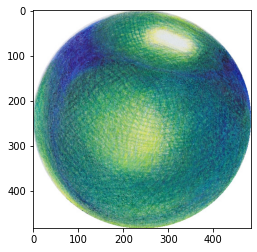

(483, 483)


(483, 483, 3)

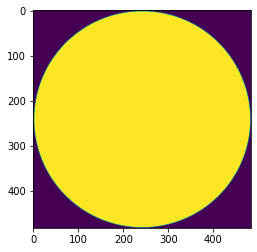

In [ ]:
g_s, a_s = load_source("05")
g_s.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  This is separate from the ipykernel package so we can avoid doing imports until


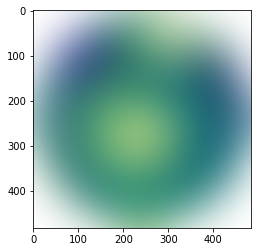

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(483, 483, 3)

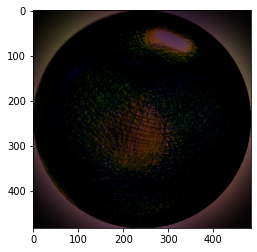

In [ ]:
B_S, D_S = base_details_layer(g_s, sigma=15)
B_S.shape

In [ ]:
def clamp(x,a,b):
   y=np.maximum(np.minimum(x,[b]),[a])
   return y

In [ ]:
x = [1,2,4]
b = 3
a = 0

clamp(np.asarray(x),a,b)

# max(x)


array([1, 2, 3])

In [ ]:
g_t.shape

(1024, 1024, 3)

In [ ]:
def base_layer(g_t, g_s):
  hs, ws = g_s.shape[:2]
  ht, wt = g_t.shape[:2]

  B_t = np.zeros((ht,wt,3))

  Q_y = np.floor(hs*(1.0 - g_t[:,:,1]))
  Qy = clamp(Q_y, 1, hs)
  Qx = clamp(np.floor(ws*g_t[:,:,0]), 1, ws)

  for i in range (0,ht):
    for j in range (0,wt):
      qy = Qy[i][j]
      qx = Qx[i][j]

      

      B_t[i,j,:] = B_S[int(qy-1),int(qx-1),:]
  
  return B_t

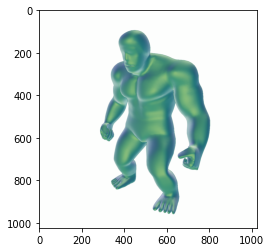

In [ ]:
B_t = base_layer(g_t,g_s)
plt.imshow(B_t)
plt.show()

In [ ]:
a = np.zeros((3,3,3))
b = np.ones((3,3,3))

In [ ]:
a[1][2][2] = b[1][2][2]
a

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [ ]:
def detail_layer(D_S, G_S, G_T, A_T, k, density,idx, G_c, P_c,C,A_X,x_roi):
  hs, ws = g_s.shape[:2]
  ht, wt = g_t.shape[:2]

  # idx, G_c, P_c,C,A_X,x_roi = feature_selection(g_t,a_t,50)
  print(P_c.shape)
  print(P_c[0][0][0:2])

  D_T = np.zeros((ht,wt,3))

  for i in range (0,ht):
    for j in range (0,wt):
      if (A_T[i][j] == 0):
        continue
      q = np.floor(P_c[i, j,0:2])
      # print(q)
      
      # q = np.reshape(q,[1,2])
      # print(q.shape)
      # print(q)

      p = [i,j]
      # p = np.reshape(p,[1,2])

      # print(np.asarray(p).shape)

      uy = np.floor(hs*(1.0 - G_c[i,j,1]))
      # print(uy)
      uy = clamp(uy,1,hs)
      # print(uy)
      ux = clamp(np.floor(ws*G_c[i,j,0]), 1, ws)

      u_q = [uy, ux]
      # print("hjhjkhkj",p[0]-q[0])
      # print(p)
      # print(q)
      u = u_q[0] + density * (p[0]-q[0])
      v = u_q[1] + density * (p[1]-q[1])
      # print(u)
      # print(u_q)
      u = np.floor(u)
      v = np.floor(v)


      u = clamp(u, 1, hs)
      v = clamp(v, 1, ws)
      # print(u)
      D_T[i, j, :] = D_S[int(u-1),int(v-1), :]


  return D_T,idx

In [ ]:
k = 10
density = 1.0
D_T, id = detail_layer(D_S, g_s, g_t, a_t, k, density,idx, G_c, P_c,C,A_X,x_roi)


(1024, 1024, 2)
[195.55555556 405.72222222]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


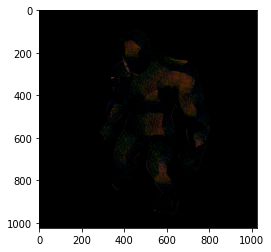

In [ ]:
plt.imshow(D_T)
plt.show()

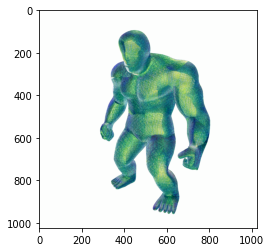

In [ ]:
C_T = B_t + D_T
C_T = clamp(C_T, 0, 1)

plt.imshow(C_T)
plt.show()

In [ ]:
p = 10
q = 5
s = [p,q]
s

In [ ]:
  [hs, ws, ~] = size(G_S);
    [ht, wt, ~] = size(G_T);
    
    [idx, G_c, P_c] = feature_clustering(G_T, A_T, k);
    
    D_T = zeros(ht, wt, 3);
    
    for py=1:ht
        for px=1:wt
            if A_T(py, px) == 0
                continue;
            end
            
            q = floor(P_c(py, px,1:2));
            q = reshape(q, 1, 2);
            
            p = [py px];
            
            uy = floor(hs*(1.0 - G_c(py,px,2)));
            uy = clamp(uy, 1, hs);
            ux = clamp(floor(ws*G_c(py,px,1)), 1, ws);
            
            u_q = [uy ux];
            
            u = u_q + density * (p-q);
            u = floor(u);
            
            u(1) = clamp(u(1), 1, hs);
            u(2) = clamp(u(2), 1, ws);
            
            D_T(py, px, :) = D_S(u(1), u(2), :);
        end
    end
end

array([[[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]]])

In [ ]:
def feature_selection_OF_IMAGE(g_s, a_s, k):
  sample_per_cluster = 32
  h,w = g_s.shape[:2]
  P, scalar = position_features(h,w)

  w_p = 4.0
  print("hello")
  X=np.dstack((g_s, w_p*P))
  # X=np.concatenate((g_t, w_p*P), axis = 2)
  # print("X: ",X)
  # print(X[0:10,0:10,0])
  X = np.reshape(X, (h*w,-1))
  print("X:",X.shape)
  # print(X[0:10,:])
  A_X = np.reshape(a_s, (h*w,-1))
  print("A_X:",A_X.shape)
  # print(A_X[0:10,:])
  x_roi,index = region_of_interest(A_X,X)
  # print(x_roi[0:10,:])
  # print(index[0:10])
 
  print("x_roi:",x_roi.shape)
  num_roi = len(x_roi)
  num_samples = sample_per_cluster * k
  num_samples = min(num_samples, num_roi)

  sample_ids = randint(num_roi, num_samples)
  x_samples = x_region_of_interest(x_roi,sample_ids)

  kmeans = KMeans(n_clusters=k, random_state=0).fit(x_samples)
  C=kmeans.cluster_centers_
  """ 
  ##dbscan
  # clustering = DBSCAN(eps=0.5, min_samples=samples_per_cluster).fit(x_samples)
  # C=clustering.components_
  """

  idx = knnsearch(C, X);

  idx=np.asarray(idx)
  print("idx:",idx.shape)
 
  G_c = []
  for i in idx:
    G_c.append(C[i,0:3])
  G_c = np.asarray(G_c)
  print(G_c.shape)

  G_c = np.reshape(G_c, (h,w,-1))
  print(G_c.shape)

  P_c = []
  for i in idx:
    P_c.append(C[i,3:5])
  
  P_c = np.asarray(P_c)

  P_c = scaler * P_c / w_p

  P_c = np.reshape(P_c, (h,w,-1))
  print("P_c shape:" , P_c.shape)

  idx = np.reshape(idx,(h,w))

  return idx, G_c, P_c,C,A_X,x_roi

In [ ]:
id, G_c_s, P_c_s, C_s, A_X_s, x_roi_s = feature_selection_OF_IMAGE(g_s, a_s, 100)

h: 486
w: 486
x:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 

In [ ]:
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

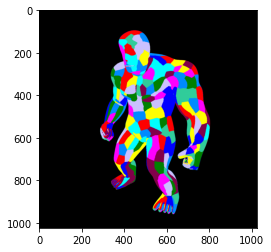

In [ ]:
L_c=label2rgb(idx)

p=np.dstack((a_t,a_t))
pq=np.dstack((p,a_t))
plt.imsave('pq.png', pq)
plt.imsave('L_c.png',L_c)

image1 = cv2.imread('pq.png')
image2 = cv2.imread('L_c.png')
# cv2_imshow(image1)
# cv2_imshow(image2)
# print(image1.shape)
# print(image2.shape)
clustered_image=cv2.bitwise_and(image1,image2)
# cv2_imshow(clustered_image)
plt.imsave("clustered_image.png",clustered_image)
final_cluster=plt.imread("clustered_image.png")
plt.imshow(final_cluster)
plt.show()

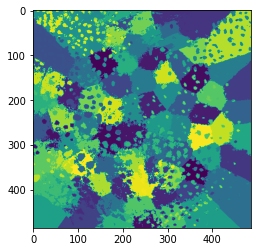

In [ ]:
plt.imshow(id)

(486, 486)


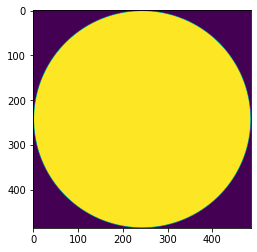

In [ ]:
plt.imshow(a_s)
print(a_s.shape)

(486, 486, 3)
(486, 486, 3)


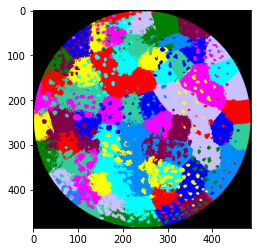

In [ ]:
L_c1=label2rgb(id)

# print(L_c1.shape)
p1=np.dstack((a_s,a_s))
# print(p1.shape)
pq1=np.dstack((p1,a_s))
plt.imsave('pq1.png', pq1)
plt.imsave('L_c1.png',L_c1)

image1_textured = cv2.imread('pq1.png')
plt.imshow(image1_textured)

image2_textured = cv2.imread('L_c1.png')
plt.imshow(image2_textured)

# cv2_imshow(image1)
# cv2_imshow(image2)
print(image1_textured.shape)
print(image2_textured.shape)
clustered_image_textured=cv2.bitwise_and(image1_textured,image2_textured)
# cv2_imshow(clustered_image)
plt.imsave("clustered_image_textured.png",clustered_image_textured)
final_cluster_textured=plt.imread("clustered_image_textured.png")
plt.imshow(final_cluster_textured)
plt.show()

In [ ]:
# def feature_selection_dbscan(g_t, a_t, k):
#   sample_per_cluster = 32
#   h,w = g_t.shape[:2]
#   P, scalar = position_features(h,w)

#   w_p = 4.0
#   print("hello")
#   X=np.dstack((g_t, w_p*P))
 
#   X = np.reshape(X, (h*w,-1))
#   print("X:",X.shape)
#   A_X = np.reshape(a_t, (h*w,-1))
#   print("A_X:",A_X.shape)
#   # print(A_X[0:10,:])
#   x_roi,index = region_of_interest(A_X,X)
#   # print(x_roi[0:10,:])
#   # print(index[0:10])
 
#   print("x_roi:",x_roi.shape)
# #   num_roi = len(x_roi)
# #   num_samples = sample_per_cluster * k
# #   num_samples = min(num_samples, num_roi)

# #   sample_ids = randint(num_roi, num_samples)
# #   x_samples = x_region_of_interest(x_roi,sample_ids)

#   # kmeans = KMeans(n_clusters=k, random_state=0).fit(x_samples)
#   # C=kmeans.cluster_centers_
#   clustering = DBSCAN(eps=0.2, min_samples=sample_per_cluster).fit(x_roi)
#   C = clustering.labels_
#   n_clusters_ = len(set(C)) - (1 if -1 in C else 0)
#   n_noise_ = list(C).count(-1)
#   print('Estimated number of clusters: %d' % n_clusters_)
#   print('Estimated number of noise points: %d' % n_noise_)

#   idx = knnsearch(C, X);

#   idx=np.asarray(idx)
#   print("idx:",idx.shape)
 
#   G_c = []
#   for i in idx:
#     G_c.append(C[i,0:3])
#   G_c = np.asarray(G_c)
#   print(G_c.shape)

#   G_c = np.reshape(G_c, (h,w,-1))
#   print(G_c.shape)

#   P_c = []
#   for i in idx:
#     P_c.append(C[i,3:5])
  
#   P_c = np.asarray(P_c)

#   P_c = scaler * P_c / w_p

#   P_c = np.reshape(P_c, (h,w,-1))
#   print("P_c shape:" , P_c.shape)

#   idx = np.reshape(idx,(h,w))

#   return idx, G_c, P_c,C,A_X,x_roi

In [ ]:
# idx, G_c, P_c,C,A_X,x_roi = feature_selection_dbscan(g_t, a_t, 5)